In [1]:
import pandas as pd
import numpy as np
from pandas.core.frame import DataFrame
import time
from geopy.distance import geodesic
import warnings
warnings.filterwarnings('ignore')

## 1 测试集的trace去训练集里面寻找
## 2根据第一条记录(真正的出发点去寻找)

In [2]:
#港口坐标数据
#港口坐标数据描述每个运单在船运的过程中涉及的港口位置信息。
port=pd.read_csv('../event_port/port.csv')

In [3]:
#gpsdf.shape
#gpsdf.to_csv('gps_sample5kw.csv',index=False)
gpsdf_raw=pd.read_csv('../clean_dataset/dataHasAllXY.csv')

KeyboardInterrupt: 

In [ ]:
gpsdf_raw.clo

In [762]:
#对数据进行预处理
def get_data(data, mode='train'):
    
    assert mode=='train' or mode=='test'
    
    if mode=='train':#船舶将要到达的下一个港口的预计时间,转码格式
        pass
    elif mode=='test':
        data['temp_timestamp'] = data['timestamp']#当前时间
        data['onboardDate'] = pd.to_datetime(data['onboardDate'], infer_datetime_format=True)#离开起运港时间
    data['timestamp'] = pd.to_datetime(data['timestamp'], infer_datetime_format=True)
    data['longitude'] = data['longitude'].astype(float)
    data['loadingOrder'] = data['loadingOrder'].astype(str)
    data['latitude'] = data['latitude'].astype(float)
    data['speed'] = data['speed'].astype(float)
    data['direction'] = data['direction'].astype(float)

    return data
#gpsdf = get_data(gpsdf_raw, mode='train')
print('finished.........')

finished.........


In [7]:
#
test_data_path='../R2 ATest 0711.csv'
df_test=pd.read_csv(test_data_path)
df_test=get_data(df_test, mode='test')
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度
#  
start_x=[]#起点
start_y=[]#起点
end_x=[]#终点
end_y=[]#终点
#存储中间结果,避免重复计算
temp_dic={}
for value in df_test['TRANSPORT_TRACE']:
    s_e=value.split('-')
    start_port=s_e[0]
    end_port=s_e[-1]
    if start_port in temp_dic:
        re=temp_dic[start_port]
    else:
        re=convert_name_xy(start_port)
        temp_dic[start_port]=re
    start_x.append(re[0])
    start_y.append(re[1])
    if end_port in temp_dic:
        re=temp_dic[end_port]
    else:
        re=convert_name_xy(end_port)
        temp_dic[end_port]=re
    end_x.append(re[0])
    end_y.append(re[1])
df_test['start_x']=start_x
df_test['start_y']=start_y
df_test['end_x']=end_x
df_test['end_y']=end_y

In [13]:
len(gpsdf['loadingOrder'].unique())

12148

In [ ]:
grouped=df_test.groupby('loadingOrder')
testStartsXY=[]
testEndXY=[]
for name,group in grouped:
    group=group.reset_index(drop=True)
    x,y=group['longitude'].values[0],group['latitude'].values[0]
    testStartsXY.append((x,y))#测试集的每一条运单的第一条记录发生地点
    x,y=group['end_x'].values[0],group['end_y'].values[0]
    testEndXY.append((x,y))
len(testStartsXY),len(testEndXY)

In [15]:
def matchs(x,y):
    for x_t,y_t in testStartsXY:
        s=geodesic((y,x), (y_t,x_t)).km
        if s<50:
            return True
    return False
def matche(x,y):
    for x_t,y_t in testEndXY:
        s=geodesic((y,x), (y_t,x_t)).km
        if s<50:
            return True
    return False
    
grouped=gpsdf.groupby('loadingOrder')
reserve_names=[]
cnt=0
for name,group in grouped:
    cnt+=1
    if cnt%1000==0:
        print(cnt)
    group=group.reset_index(drop=True)
    x0,y0=group['longitude'].values[0],group['latitude'].values[0]
    x1,y1=group['longitude'].values[-1],group['latitude'].values[-1]
    
    if matchs(x0,y0) and matche(x1,y1):
        reserve_names.append(name)
gpsdf=gpsdf[gpsdf['loadingOrder'].isin(reserve_names)]
gpsdf=gpsdf.reset_index(drop=True)
print('finished.........')
len(reserve_names)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
finished.........


6642

In [763]:
#gpsdf.to_csv("筛选的训练data.csv",index=False)
gpsdf=pd.read_csv("筛选的训练data.csv")
gpsdf = get_data(gpsdf, mode='train')

In [764]:
#清洗训练数据(针对标签的清洗，因为有很多运单中间大量停船过程)
grouped=gpsdf.groupby('loadingOrder')
cnt_maxtime=[]
reserve_name=[]
for name,group in grouped:
    group=group.reset_index(drop=True)
    time_dif=group['timestamp'].diff(1).dt.total_seconds()//3600#小时为单位
    time_dif=time_dif.values[1:]
    if len(time_dif)<50:
        reserve_name.append(name)
        continue
    cnt_maxtime.append(np.max(time_dif))
    if np.max(time_dif)<10:#跳跃小于10个小时的用于训练
        reserve_name.append(name)
    #break
gpsdf=gpsdf[gpsdf['loadingOrder'].isin(reserve_name)]
gpsdf=gpsdf.reset_index(drop=True)

In [765]:
sorted(cnt_maxtime,reverse=True)[3000]#可以看到，最大的时间间隔已经是952个小时，这种运单显然不对

10.0

In [766]:
grouped=gpsdf.groupby('loadingOrder')
cnt_turn=[]
for name,group in grouped:
    group=group.reset_index(drop=True)
    trace=group['TRANSPORT_TRACE'].values[0]
    trace=trace.split('-')
    cnt_turn.append(len(trace)-2)
    #print(trace)
    

In [904]:
import time
import datetime
from geopy.distance import geodesic
#
def cut_zero_end(data):
    for i in range(len(data)-1,0,-1):
        if data[i]!=0:
            break
    return i+1
def cut_zero_start(data):
    for i in range(len(data)):
        if data[i]!=0:
            break
    return i-1
#
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度

def get_train_feature(df):
    #
    #构建年份,月份特征
    y_m=str(df['timestamp'].values[0])
    year=int(y_m.split('-')[0])
    month=y_m.split('-')[1]
    if month[0]=='0':
        month=int(month[1])
    else:
        month=int(month)
    #
    portNames=df['TRANSPORT_TRACE'].values[0]
    portNames=portNames.split('-')
    cnt_turn=len(portNames)-2
    data=list(df['speed'])
    cut_start=0
    cut_end=len(df)
    #if data[0]==0:
        #cut_start=cut_zero_start(data)
    if data[-1]==0:
        cut_end=cut_zero_end(data)
    df=df[cut_start:cut_end].reset_index(drop=True)
    if len(df)<10:
        return [0 for i in range(39)]
    feature=[]
    length=len(df)
    sx=df['longitude'][0]
    sy=df['latitude'][0]
    ex=df['longitude'][length-1]
    ey=df['latitude'][length-1]
    
    dis=geodesic((sy,sx), (ey,ex)).km
    lon_dis=abs(ex-sx)
    lat_dis=abs(ey-sy)
    dis_sqrt=np.sqrt(lon_dis*lon_dis+lat_dis*lat_dis)
    
    dir_k=lat_dis/lon_dis
    label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    #下面开始截断
    if length<200:
        cut_ratio=0.5
    else:
        cut_ratio=random.choice([0.1,0.15,0.2,0.25,0.3])
        #cut_ratio=random.choice([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])
    df=df[:int(length*cut_ratio)]
    
    length=len(df)
    dsx=df['longitude'][0]
    dsy=df['latitude'][0]
    dex=df['longitude'][length-1]
    dey=df['latitude'][length-1]
    cal_dis=geodesic((dsy,dsx), (dey,dex)).km#截取出来的一段距离
    cut_label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    
    cal_speed=cal_dis/(cut_label+0.1)

    df['lat_diff']=df['latitude'].diff(1)
    df['lon_diff']=df['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    #
    df['speed_diff'] = df['speed'].diff(1)#速度变化量
    df['diff_minutes'] =df['timestamp'].diff(1).dt.total_seconds() / 60#记录之间的间隔时间(单位:s)
    #
    k_1_4=df['k'].quantile(0.25)
    k_median=df['k'].quantile(0.5)
    k_3_4=df['k'].quantile(0.75)
    #在所有的记录中，多少记录是停船状态
    #df['anchor'] = ((df['lat_diff'] <= 0.03) & (df['lon_diff'] <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] <= 10)).astype(int)
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 10)).astype(int)

    anchor_cnt = df['anchor'].sum()
    anchor_ratio = anchor_cnt / len(df)
    
    
    #
    lat_1_4=df['latitude'].quantile(0.25)
    lat_3_4=df['latitude'].quantile(0.75)
    lat_min=df['latitude'].min()
    lat_max=df['latitude'].max()
    lat_mean=df['latitude'].mean()
    lat_median=df['latitude'].median()
    #
    lon_1_4=df['longitude'].quantile(0.25)
    lon_3_4=df['longitude'].quantile(0.75)
    longitude_1_4=df['longitude'].quantile(0.25)
    longitude_3_4=df['longitude'].quantile(0.75)
    lon_min=df['longitude'].min()
    lon_max=df['longitude'].max()
    lon_mean=df['longitude'].mean()
    lon_median=df['longitude'].median()
    #
    speed_1_4=df['speed'].quantile(0.25)
    speed_3_4=df['speed'].quantile(0.75)
    speed_max=df['speed'].max()
    speed_mean=df['speed'].mean()
    speed_median=df['speed'].median()
    #
    direction_1_4=df['direction'].quantile(0.25)
    direction_3_4=df['direction'].quantile(0.75)
    direction_min=df['direction'].min()
    direction_max=df['direction'].max()
    direction_mean=df['direction'].mean()
    direction_median=df['direction'].median()
    #
    feature.append(k_1_4)
    feature.append(k_3_4)
    feature.append(k_median)
    feature.append(anchor_cnt)
    feature.append(anchor_ratio)
    #
    feature.append(lat_1_4)
    feature.append(lat_3_4)
    feature.append(lat_max)
    feature.append(lat_min)
    feature.append(lat_median)
    feature.append(lat_mean)
    #
    feature.append(lon_1_4)
    feature.append(lon_3_4)
    feature.append(lon_max)
    feature.append(lon_min)
    feature.append(lon_median)
    feature.append(lon_mean)
    #
    feature.append(speed_1_4)
    feature.append(speed_3_4)
    feature.append(speed_max)
    feature.append(speed_median)
    feature.append(speed_mean)
    #
    feature.append(direction_1_4)
    feature.append(direction_3_4)
    feature.append(direction_max)
    feature.append(direction_min)
    feature.append(direction_median)
    feature.append(direction_mean)
    #
    feature.append(sx)
    feature.append(sy)
    feature.append(ex)
    feature.append(ey)
    feature.append(dis)
    feature.append(lon_dis)
    feature.append(lat_dis)
    feature.append(cal_speed)
    feature.append(dis_sqrt)
    feature.append(cnt_turn)
    feature.append(year)
    feature.append(month)
    feature.append(abs(dir_k))
    feature.append(label)

    return feature
#
import random
from geopy.distance import geodesic
import time
def make_train_data(df):
    features=[]
    grouped=df.groupby('loadingOrder')
    #
    start_time=time.time()
    print('正在构造训练数据')
    start_time=time.time()
    for name,group in grouped:
        #sample_trace=df.loc[group.index[bottom:top+1]].reset_index(drop=True)#这里的sample_trace是截取出的一段轨迹(一个训练样本)
        sample_trace=group.reset_index(drop=True)
        features.append(get_train_feature(sample_trace))
    print("构造训练特征所花费时间%.3fs"%(time.time()-start_time))
    return features
#
train_features=make_train_data(gpsdf)

正在构造训练数据
构造训练特征所花费时间54.874s


## 观察训练数据标签的分布
- 最长时间:86.28858796296296 day
- 最短时间:0.0 day
- 平均时间:16.70094809971483 day

## 而测试数据中已知的轨迹长度为：
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day


In [905]:
#
test_data_path='../R2 ATest 0711Clean.csv'
df_test=pd.read_csv(test_data_path)
df_test=get_data(df_test, mode='test')

In [906]:
#df_test[df_test['loadingOrder'].isin(['KD265061648304'])]#1-12日出发，1-16开始截取

In [907]:
#判断onboard_time和第一条记录的时间是否相等
#总共10个运单的onboard/第一条时间差距大于一个小时，大于一天的有两个运单
#'DH829189593918':105h;'LE381377964668':68.0
grouped=df_test.groupby('loadingOrder',sort=False)
cnt=0
for name,group in grouped:
    group=group.reset_index(drop=True)
    dft=pd.to_datetime(group['timestamp'] ).apply(lambda x: x.replace(tzinfo=None))
    delta=(dft[:1][0]-group['onboardDate'][:1][0]).total_seconds()//3600
    if delta!=0:
        print(name,delta)#总共10个运单的onboard和第一条时间戳不一致
    if name=='DH829189593918' or name=='LE381377964668':
        print(cnt,delta)
    cnt+=1
#这里面的10个不一致的订单是需要最好减掉的

SZ109188860665 1.0
NH240192470616 3.0
JB123387157454 3.0
ZO975754571124 3.0
DH829189593918 105.0
80 105.0
LE381377964668 68.0
89 68.0
ZX552539758501 1.0
TB846768731403 4.0
HQ193237808500 1.0
QK696918637480 8.0


In [908]:
'''
len_list=[]
delta=[]
grouped=df_test.groupby('loadingOrder')
for name,group in grouped:
    len_list.append(len(group))
    group=group.reset_index(drop=True)
    tmp=group['timestamp'].values
    delta.append(pd.Timedelta((tmp[-1]-tmp[1])).total_seconds()/3600/24)
    if len(group)<10:
        print(name)

print(np.min(len_list),np.mean(len_list),np.max(len_list))
    
print(np.min(delta),np.mean(delta),np.max(delta))
'''


"\nlen_list=[]\ndelta=[]\ngrouped=df_test.groupby('loadingOrder')\nfor name,group in grouped:\n    len_list.append(len(group))\n    group=group.reset_index(drop=True)\n    tmp=group['timestamp'].values\n    delta.append(pd.Timedelta((tmp[-1]-tmp[1])).total_seconds()/3600/24)\n    if len(group)<10:\n        print(name)\n\nprint(np.min(len_list),np.mean(len_list),np.max(len_list))\n    \nprint(np.min(delta),np.mean(delta),np.max(delta))\n"

In [909]:
#sorted(len_list)

# 测试数据:共94对(31对中间港口，最多中间港有14个)港口，219条运单，其中很多含有中间港口

In [910]:
def convert_name_xy(name):#输入港口名称
    port_name=port[port['TRANS_NODE_NAME'].isin([name])].reset_index()
    return port_name['LONGITUDE'][0],port_name['LATITUDE'][0]#返回港口经纬度
#  
start_x=[]#起点
start_y=[]#起点
end_x=[]#终点
end_y=[]#终点
#存储中间结果,避免重复计算
temp_dic={}
for value in df_test['TRANSPORT_TRACE']:
    s_e=value.split('-')
    start_port=s_e[0]
    end_port=s_e[-1]
    if start_port in temp_dic:
        re=temp_dic[start_port]
    else:
        re=convert_name_xy(start_port)
        temp_dic[start_port]=re
    start_x.append(re[0])
    start_y.append(re[1])
    if end_port in temp_dic:
        re=temp_dic[end_port]
    else:
        re=convert_name_xy(end_port)
        temp_dic[end_port]=re
    end_x.append(re[0])
    end_y.append(re[1])
df_test['start_x']=start_x
df_test['start_y']=start_y
df_test['end_x']=end_x
df_test['end_y']=end_y

In [911]:
import time
from geopy.distance import geodesic
#
def get_test_feature(df,name):
    #
    y_m=str(df['timestamp'].values[0])
    year=int(y_m.split('-')[0])
    month=y_m.split('-')[1]
    if month[0]=='0':
        month=int(month[1])
    else:
        month=int(month)
    #
    portNames=df['TRANSPORT_TRACE'].values[0]
    portNames=portNames.split('-')
    cnt_turn=len(portNames)-2
    df.sort_values(['timestamp'], inplace=True)
    df=df.reset_index(drop=True)
    feature=[]
    length=len(df)
    dsx=df['longitude'][0]
    dsy=df['latitude'][0]
    dex=df['longitude'][length-1]
    dey=df['latitude'][length-1]
    #
    sx=df['longitude'][0]#df['start_x'][0]
    sy=df['latitude'][0]#df['start_y'][0]
    ex=df['end_x'][length-1]
    ey=df['end_y'][length-1]
    
    dis=geodesic((sy,sx), (ey,ex)).km
    lon_dis=abs(ex-sx)
    lat_dis=abs(ey-sy)
    dis_sqrt=np.sqrt(lon_dis*lon_dis+lat_dis*lat_dis)
    
    dir_k=lat_dis/lon_dis
    
    label=(df['timestamp'][length-1]-df['timestamp'][0]).total_seconds()/3600
    cal_dis=geodesic((dsy,dsx), (dey,dex)).km
    cal_speed=cal_dis/(label+0.1)
    df['lat_diff']=df['latitude'].diff(1)
    df['lon_diff']=df['longitude'].diff(1)
    df['k']=df['lat_diff']/df['lon_diff']
    #
    df['speed_diff'] = df['speed'].diff(1)#速度变化量
    df['diff_minutes'] =df['timestamp'].diff(1).dt.total_seconds() / 60#记录之间的间隔时间(单位:s)
    #
    k_1_4=df['k'].quantile(0.25)
    k_median=df['k'].quantile(0.5)
    k_3_4=df['k'].quantile(0.75)
    #在所有的记录中，多少记录是停船状态
    df['anchor'] = ((df['lat_diff'].abs() <= 0.03) & (df['lon_diff'].abs() <= 0.03)& (df['speed_diff'] <= 0.3) & (df['diff_minutes'] >= 15)).astype(int)

    anchor_cnt = df['anchor'].sum()
    anchor_ratio = anchor_cnt / len(df)
    #
    lat_1_4=df['latitude'].quantile(0.25)
    lat_3_4=df['latitude'].quantile(0.75)
    lat_min=df['latitude'].min()
    lat_max=df['latitude'].max()
    lat_mean=df['latitude'].mean()
    lat_median=df['latitude'].median()
    #
    lon_1_4=df['longitude'].quantile(0.25)
    lon_3_4=df['longitude'].quantile(0.75)
    longitude_1_4=df['longitude'].quantile(0.25)
    longitude_3_4=df['longitude'].quantile(0.75)
    lon_min=df['longitude'].min()
    lon_max=df['longitude'].max()
    lon_mean=df['longitude'].mean()
    lon_median=df['longitude'].median()
    #
    speed_1_4=df['speed'].quantile(0.25)
    speed_3_4=df['speed'].quantile(0.75)
    speed_min=df['speed'].min()
    speed_max=df['speed'].max()
    speed_mean=df['speed'].mean()
    speed_median=df['speed'].median()
    #
    direction_1_4=df['direction'].quantile(0.25)
    direction_3_4=df['direction'].quantile(0.75)
    direction_min=df['direction'].min()
    direction_max=df['direction'].max()
    direction_mean=df['direction'].mean()
    direction_median=df['direction'].median()
    #
    feature.append(name)
    feature.append(k_1_4)
    feature.append(k_3_4)
    feature.append(k_median)
    feature.append(anchor_cnt)
    feature.append(anchor_ratio)
    #
    feature.append(lat_1_4)
    feature.append(lat_3_4)
    feature.append(lat_max)
    feature.append(lat_min)
    feature.append(lat_median)
    feature.append(lat_mean)
    #
    feature.append(lon_1_4)
    feature.append(lon_3_4)
    feature.append(lon_max)
    feature.append(lon_min)
    feature.append(lon_median)
    feature.append(lon_mean)
    #
    feature.append(speed_1_4)
    feature.append(speed_3_4)
    feature.append(speed_max)
    feature.append(speed_median)
    feature.append(speed_mean)
    #
    feature.append(direction_1_4)
    feature.append(direction_3_4)
    feature.append(direction_max)
    feature.append(direction_min)
    feature.append(direction_median)
    feature.append(direction_mean)
    #
    feature.append(sx)
    feature.append(sy)
    feature.append(ex)
    feature.append(ey)
    feature.append(dis)
    feature.append(lon_dis)
    feature.append(lat_dis)
    feature.append(cal_speed)
    feature.append(dis_sqrt)
    feature.append(cnt_turn)
    feature.append(year)
    feature.append(month)
    feature.append(abs(dir_k))
    feature.append(label)
    
    return feature
#
import random
from geopy.distance import geodesic
import time
def make_test_data(df):
    features=[]
    grouped=df.groupby('loadingOrder',sort=False)
    print('finished1...')
    #
    start_time=time.time()
    print('正在构造测试数据........')
    start_time=time.time()
    for name,group in grouped:
        #
        sample_trace=group.reset_index(drop=True)
        features.append(get_test_feature(sample_trace,name))
    print("构造测试数据所花费时间%.3fs"%(time.time()-start_time))
    return features
#下面只需要保留原始数据cut之前的数据
test_features=make_test_data(df_test)

finished1...
正在构造测试数据........
构造测试数据所花费时间2.678s


In [912]:
train=DataFrame(train_features)
train.columns=['k_1_4','k_3_4','k_median','anchor_cnt','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt','cnt_turn','year','month','dir_k','label']
train=train[train['label']>0.02*24]#筛选训练样本，0.05天以内的不予考虑
train=train[train['label']<80*24]
train.shape
test=DataFrame(test_features)
test.columns=['loadingOrder','k_1_4','k_3_4','k_median','anchor_cnt','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt','cnt_turn','year','month','dir_k','label']

最长时间:50.528182870370365 day
最短时间:0.023506944444444445 day
平均时间:16.74551449141875 day


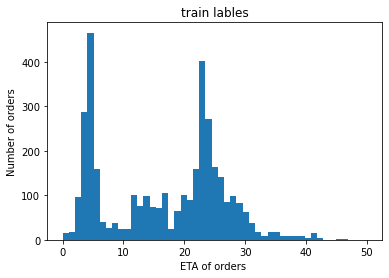

In [913]:

train_label=np.array(train['label']/24)

##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(train_label)))
print("最短时间:%s day"%np.min(train_label))
print("平均时间:%s day"%np.mean(train_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(train_label)),int(max(train_label)),int(max(train_label)))
plt.hist(train_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('train lables')
plt.show()

## 观察下测试集中给了多少天的轨迹数据
- 最长时间:16.88171296296296 day
- 最短时间:0.046527777777777786 day
- 平均时间:4.325498415081749 day

最长时间:26.122685185185187 day
最短时间:0.004050925925925926 day
平均时间:2.532971064814815 day


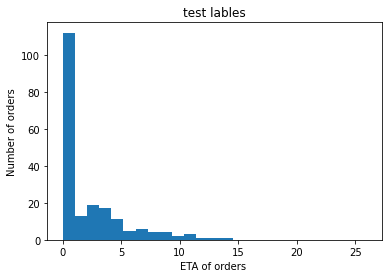

In [914]:
#观察下测试集中给了多少天的轨迹数据
test_label=np.array(test['label']/24)
##观察下预测结果的分布
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("最长时间:%s day"%(np.max(test_label)))
print("最短时间:%s day"%np.min(test_label))
print("平均时间:%s day"%np.mean(test_label))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(test_label)),int(max(test_label)),int(max(test_label)))
plt.hist(test_label,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.title('test lables')
plt.show()

## 搭建训练模型

## xgb+lgb

In [915]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import pandas as pd
from tqdm import tqdm
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error,explained_variance_score
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt
#from featexp import get_univariate_plots#用于特征筛选，需要先安装featexp
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [967]:
#
features =['k_1_4','k_3_4','k_median','anchor_ratio','lat_1_4','lat_3_4','lat_max','lat_min'
    ,'lat_median','lat_mean','lon_1_4','lon_3_4','lon_max','lon_min','lon_median','lon_mean'
    'speed_1_4','speed_3_4','speed_min','speed_max','speed_median','speed_mean','direction_1_4','direction_3_4','direction_max'
    ,'direction_min','direction_median','direction_mean','sx','sy','ex','ey'
    ,'dis','lon_dis','lat_dis','cal_speed','dis_sqrt','month','cnt_turn']
train_data=train[features]
test_data=test[features]
y=train['label']
train_data.shape,test_data.shape

((3619, 38), (200, 38))

In [957]:

features =['lat_1_4', 'anchor_ratio', 'lon_max', 'direction_3_4', 'ex',
       'k_median', 'lon_dis', 'direction_1_4', 'sy', 'k_3_4',
       'direction_max', 'ey', 'speed_mean', 'dis', 'k_1_4', 'sx',
       'lat_dis', 'cal_speed']
train_data=train[features]
test_data=test[features]
y=train['label']
train_data.shape,test_data.shape



((3619, 17), (200, 17))

In [958]:
#featuresx=[ 'dis','lon_dis','lat_dis','cal_speed']
#train_data=train_data[featuresx]
#test_data=test_data[featuresx]

In [959]:
'''pseudo_label=pd.Series(np.load('../submit/3_5k.npy'))
pseudo_X=pd.concat((train_data,test_data))
pseudo_X=pseudo_X.reset_index(drop=True)
pseudo_y=pd.concat((y,pseudo_label))
pseudo_y=pseudo_y.reset_index(drop=True)
y=pseudo_y
train_data=pseudo_X

'''


"pseudo_label=pd.Series(np.load('../submit/3_5k.npy'))\npseudo_X=pd.concat((train_data,test_data))\npseudo_X=pseudo_X.reset_index(drop=True)\npseudo_y=pd.concat((y,pseudo_label))\npseudo_y=pseudo_y.reset_index(drop=True)\ny=pseudo_y\ntrain_data=pseudo_X\n\n"

In [968]:
x_train,x_test,y_train,y_test=train_test_split(train_data,y,test_size=0.1,random_state=2020)

In [969]:
x_train.shape,x_test.shape

((3257, 38), (362, 38))

In [970]:
llf=gbm = lgb.LGBMRegressor(objective='regression',
                        num_leaves=31,
                        learning_rate=0.1,
                        n_estimators=1000)

llf.fit(x_train,y_train)

llf_val_mse=mean_squared_error(y_test,llf.predict(x_test))
llf_train_mse=mean_squared_error(y_train,llf.predict(x_train))
print('val_mse:','{:e}'.format(llf_val_mse))
print('train_mse:','{:e}'.format(llf_train_mse))

val_mse: 2.172651e+03
train_mse: 2.027569e+00


In [971]:
details=[]
answers=np.zeros(len(test))
n_splits=5
cnt=0
mean_error=0
sk=KFold(n_splits=n_splits,shuffle=True,random_state=2020)
for train_k,test_k in sk.split(train_data,y):
    cnt+=1
    x_train=train_data.iloc[train_k]
    y_train=y.iloc[train_k]
    x_test=train_data.iloc[test_k]
    y_test=y.iloc[test_k]
    llf.fit(x_train,y_train)
    error=mean_squared_error(y_test,llf.predict(x_test))
    print("第%d次验证mse误差为%f" %(cnt,error))
    mean_error+=error/n_splits
    test_lgb=llf.predict(test_data)
    answers+=test_lgb/n_splits
print("平均验证误差%f"%mean_error)

第1次验证mse误差为1266.294991
第2次验证mse误差为800.564648
第3次验证mse误差为700.657593
第4次验证mse误差为1530.051113
第5次验证mse误差为1152.972464
平均验证误差1090.108162


## 观察训练/验证过程

## 观察预测结果的分布

预测的最长时间:36.659695371021115 day
预测的最短时间:0.6236526555497884 day
预测的平均时间:14.249728726451485 day


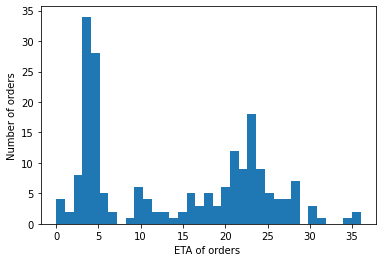

In [972]:
##观察下预测结果的分布
re_day=answers/24
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("预测的最长时间:%s day"%(np.max(re_day)))
print("预测的最短时间:%s day"%np.min(re_day))
print("预测的平均时间:%s day"%np.mean(re_day))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(re_day)),int(max(re_day)),int(max(re_day)))
plt.hist(re_day,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.show()
plt.close()

预测的最长时间:37.02103935185185 day
预测的最短时间:0.4782069444444444 day
预测的平均时间:14.953154671547331 day


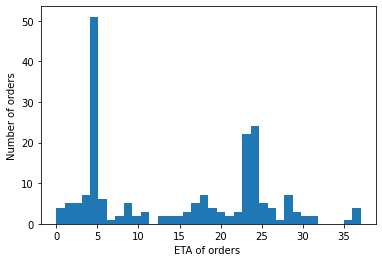

In [973]:
##观察下ans6k结果的分布
ans1_5k=np.load('../submit/1_5k.npy')
re_day=ans1_5k/24
name_cnt={}#{订单号：对应的事件记录条数}
tmp=[]
print("预测的最长时间:%s day"%(np.max(re_day)))
print("预测的最短时间:%s day"%np.min(re_day))
print("预测的平均时间:%s day"%np.mean(re_day))
#画出分布直方图
import pylab as plt 
bins = np.linspace(int(min(re_day)),int(max(re_day)),int(max(re_day)))
plt.hist(re_day,bins)
plt.xlabel('ETA of orders ')
plt.ylabel('Number of orders')
plt.show()
plt.close()

In [974]:
#
ans1_5k=np.load('../submit/1_5k.npy')
ans_10k=np.load('../submit/ans_10k.npy')
ans6_9k=np.load('../submit/rxd_6k9.npy')
print("answer与ans1_5k的mse:%.0f"%mean_squared_error(answers,ans1_5k))
print("answer与ans_10k的mse:%.0f"%mean_squared_error(answers,ans_10k))
print("answer与ans6_9k的mse:%.0f"%mean_squared_error(answers,ans6_9k))
print("ans_10k与ans1_5k的mse:%.0f"%mean_squared_error(ans1_5k,ans_10k))
print("ans6_9k与ans1_5k的mse:%.0f"%mean_squared_error(ans1_5k,ans6_9k))

answer与ans1_5k的mse:3756
answer与ans_10k的mse:3490
answer与ans6_9k的mse:5551
ans_10k与ans1_5k的mse:4251
ans6_9k与ans1_5k的mse:3302


SZ109188860665 1.0
NH240192470616 3.0
JB123387157454 3.0
ZO975754571124 3.0
DH829189593918 105.0
86 105.0
LE381377964668 68.0
95 68.0
ZX552539758501 1.0
TB846768731403 4.0
HQ193237808500 1.0
QK696918637480 8.0

In [937]:
answers[80],answers[89]

(-24.443874691245107, 7.164669511975632)

In [938]:
tmp=abs(answers-ans1_5k)
for i in range(len(tmp)):
    if tmp[i]>200:
        print(i)

8
61
126
133
135
137
152
174
177
178


In [939]:
grouped=df_test.groupby('loadingOrder',sort=False)
cnt=0
for name,group in grouped:
    if cnt in [133,135,152,174]:
        print(name)
    cnt+=1

HB956271385453
JV646262964847
XW126071516605
QX924743867365


## 特征重要度筛选

<Figure size 1296x648 with 0 Axes>

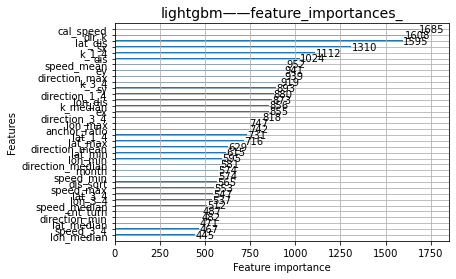

In [940]:
plt.figure(figsize=(18,9))
lgb.plot_importance(llf,max_num_features=36)
plt.title('lightgbm——feature_importances_',fontsize=14)
plt.show()

In [941]:
importance=pd.DataFrame({
        'column': train_data.columns,
        'importance': llf.booster_.feature_importance(),
    }).sort_values(by='importance')
importance=importance.reset_index(drop=True)
importance['column'].values[20:]

array(['lat_1_4', 'anchor_ratio', 'lon_max', 'direction_3_4', 'ex',
       'k_median', 'lon_dis', 'direction_1_4', 'sy', 'k_3_4',
       'direction_max', 'ey', 'speed_mean', 'dis', 'k_1_4', 'sx',
       'lat_dis', 'dir_k', 'cal_speed'], dtype=object)

## 生成提交文件

DH829189593918 105.0
24 105.0
LE381377964668 68.0
87,68.0

In [366]:
test['label'] = answers
result=test[['loadingOrder', 'label']]
test_data_path = '../R2 ATest 0711Clean.csv'
test_data=pd.read_csv(test_data_path)
test_data=get_data(test_data, mode='test')
#
test_data = test_data.merge(result, on='loadingOrder', how='left')
test_data['ETA'] = (test_data['onboardDate'] + test_data['label'].apply(lambda x:pd.Timedelta(hours=x))).apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data.drop(['direction','TRANSPORT_TRACE'],axis=1,inplace=True)
test_data['onboardDate'] = test_data['onboardDate'].apply(lambda x:x.strftime('%Y/%m/%d  %H:%M:%S'))
test_data['creatDate'] = pd.datetime.now().strftime('%Y/%m/%d  %H:%M:%S')
test_data['timestamp'] = test_data['temp_timestamp']
# 整理columns顺序
submit = test_data[['loadingOrder', 'timestamp', 'longitude', 'latitude', 'carrierName', 'vesselMMSI', 'onboardDate', 'ETA', 'creatDate']]

In [370]:
submit[submit['loadingOrder'].isin(['LE381377964668'])]#FA712454830300

,loadingOrder,timestamp,longitude,latitude,carrierName,vesselMMSI,onboardDate,ETA,creatDate
28744,LE381377964668,2020-01-29T11:16:48.000Z,105.483728,3.496902,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28745,LE381377964668,2020-01-29T11:24:58.000Z,105.463333,3.462403,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28746,LE381377964668,2020-01-29T11:26:58.000Z,105.458357,3.454005,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28747,LE381377964668,2020-01-29T11:51:58.000Z,105.392875,3.350885,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28748,LE381377964668,2020-01-29T11:52:28.000Z,105.391335,3.348983,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28749,LE381377964668,2020-01-29T11:59:58.000Z,105.368168,3.320680,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28750,LE381377964668,2020-01-29T12:04:28.000Z,105.354298,3.303697,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28751,LE381377964668,2020-01-29T12:06:58.000Z,105.346595,3.294242,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28752,LE381377964668,2020-01-29T12:19:28.000Z,105.308082,3.246950,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27
28753,LE381377964668,2020-01-29T12:39:48.000Z,105.250933,3.165947,OIEQNT,Q4244189904,2020/01/26 15:01:58,2020/01/27 05:34:29,2020/08/02 18:06:27


In [371]:
submit.to_csv('../submit/83v1.csv', index=False)

In [372]:
np.save('../submit/83v1.npy',answers)